In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
condition_key = 'study'
cell_type_key = 'cell_type'

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [7]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd 



In [8]:
adata_all = sc.read('pancreas.h5ad')

In [9]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
conditions = adata.obs[condition_key].unique().tolist()
conditions, adata

(['Pancreas inDrop',
  'Pancreas CelSeq2',
  'Pancreas CelSeq',
  'Pancreas Fluidigm C1',
  'Pancreas SS2'],
 AnnData object with n_obs × n_vars = 15681 × 1000
     obs: 'batch', 'study', 'cell_type', 'size_factors')

In [10]:
trvae = sca.models.TRVAE(
    adata=adata,
    condition_key=condition_key,
    conditions=conditions,
    hidden_layer_sizes=[128, 128],
 )


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [11]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

 |██------------------| 12.4%  - val_loss: 740.5811673678 - val_recon_loss: 715.6846454327 - val_kl_loss: 22.4338152959 - val_mmd_loss: 18.05420259333
ADJUSTED LR
 |███-----------------| 17.4%  - val_loss: 740.3413461538 - val_recon_loss: 714.5576923077 - val_kl_loss: 20.6958464109 - val_mmd_loss: 16.8844397618
ADJUSTED LR
 |████----------------| 20.6%  - val_loss: 747.9072829026 - val_recon_loss: 720.1032057542 - val_kl_loss: 20.0983478840 - val_mmd_loss: 17.5539156107
ADJUSTED LR
 |████----------------| 23.6%  - val_loss: 737.6252253606 - val_recon_loss: 709.2980018029 - val_kl_loss: 19.8130550385 - val_mmd_loss: 16.7365895785
ADJUSTED LR
 |█████---------------| 27.8%  - val_loss: 739.9456129808 - val_recon_loss: 711.0353675255 - val_kl_loss: 19.7001627409 - val_mmd_loss: 15.3171388186
ADJUSTED LR
 |█████---------------| 29.2%  - val_loss: 762.2383422852 - val_recon_loss: 731.1495079627 - val_kl_loss: 19.8112298525 - val_mmd_loss: 16.7256861467
Stopping early: no improvement of more 

In [12]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = adata.obs[condition_key].tolist()

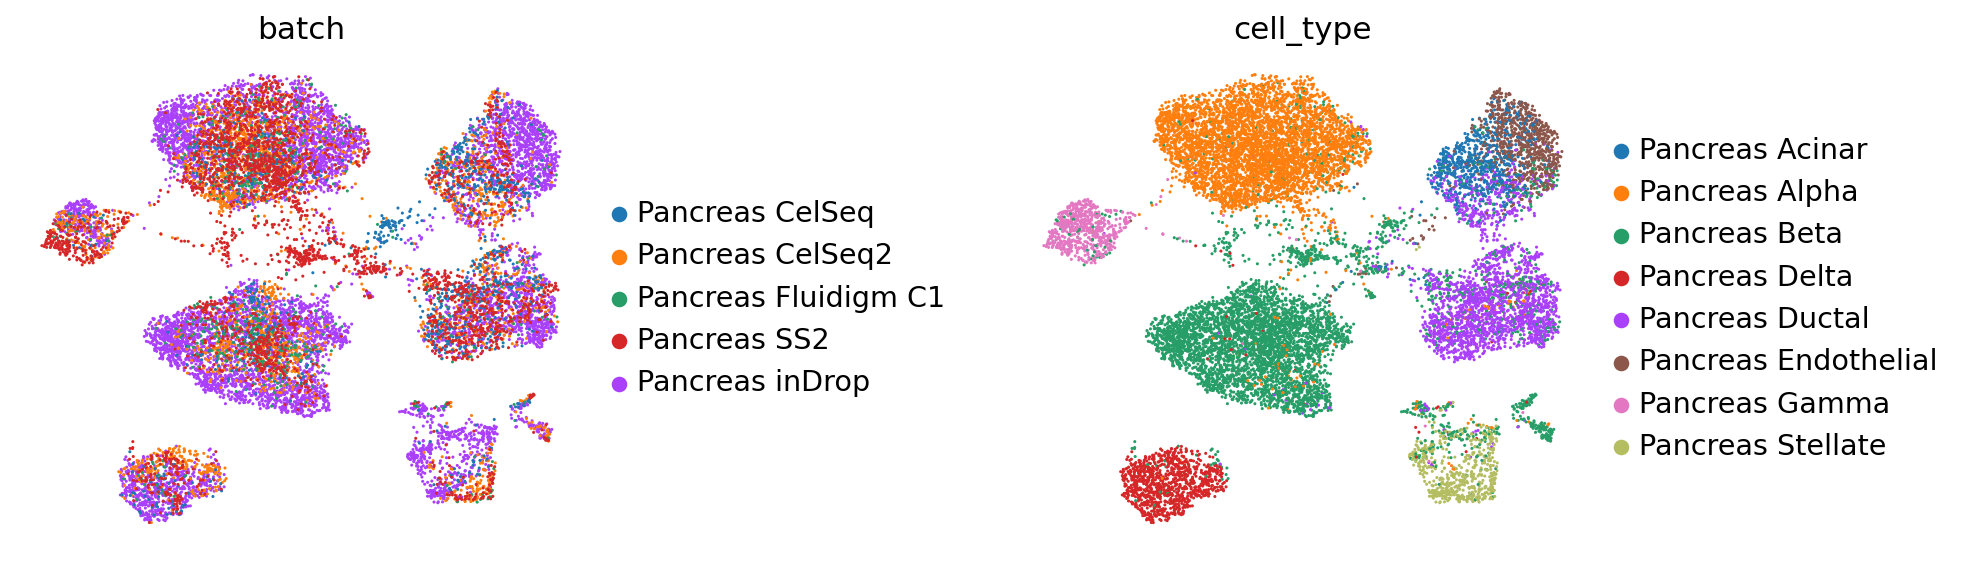

In [13]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [14]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [15]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:28:51


In [16]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(adata_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_std=scib.metrics.graph_connectivity(adata_latent, 'batch')


Batch_corr_graph_conn_std

0.6525543008643219

In [17]:
sc.tl.umap(adata_latent)
Batch_corr_ASW_std=scib.metrics.silhouette_batch(adata_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_std

mean silhouette per group:                       silhouette_score
group                                 
Pancreas Acinar               0.794936
Pancreas Alpha                0.868415
Pancreas Beta                 0.846121
Pancreas Delta                0.835249
Pancreas Ductal               0.860719
Pancreas Endothelial          0.814961
Pancreas Gamma                0.825720
Pancreas Stellate             0.782766


0.8286109488080287

In [18]:
Bio_cons_ASW_std=scib.metrics.silhouette(adata_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_std

0.6770734935998917

In [19]:
isolated_labels_rehearsal=scib.metrics.isolated_labels(adata_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_rehearsal


isolated labels: no more than 5 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Acinar: 0.5888019265502709


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Alpha: 0.9660209590346142


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Beta: 0.8415508740475123


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Delta: 0.9657831325301205


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Ductal: 0.8182696955050749


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Endothelial: 0.7533185840707965


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Gamma: 0.9513677811550153


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Stellate: 0.8730158730158729


0.8447661032386597